In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sbn

sbn.set()

# Exercise 1: Linear Congruential Generator

In [47]:
def LCG(a = 5, c = 1, M = 16, x0 = 3, n = 10000):
    """ Linear congruential generator for generating psuedo random numbers"""
    x = np.zeros(n)
    x[0] = x0

    for i in range(1, n):
        x[i] = int((a * x[i - 1] + c ) % M)

    return x.astype(int)

def test_chi_square(U):
    """ Compute the p-value of the null-hypothesis that the pseudo-random
        numbers come from a uniform distribution. """
    n = U.shape[0]
    
    k = int(n / 500)

    n_observed = np.histogram(U, bins=k, range=(0,1))[0]
    
    # Compute test statistics
    n_expected = n / k # Choose n_expected >= 5
    Z = ((n_observed - n_expected) ** 2 / n_expected).sum() # test statistic
    
    p = 1 - stats.chi2.cdf(Z, df = k - 1)

    return Z, p # (test statistic, p-value)

def test_ks(U):
    """ Kolmogorov-Smirnov test """
    n = U.shape[0]

    Fxn = U.copy()
    Fxn.sort()

    # Fxn = ECDF(U).x[1:] # Empirical distribution
    
    Fx = np.linspace(0, 1, n) # Hypothesised uniform distribution
    
    Dn = np.abs(Fxn - Fx).max() # Test statistic
    Dn_adjusted = (np.sqrt(n) + .12 + .11 / np.sqrt(n)) * Dn

    # p_value
    p = 1 - stats.kstwobign.cdf(Dn_adjusted)

    # p = stats.kstwo.sf(Dn_adjusted, 1)

    return Dn_adjusted, p

def test_above_below(U):
    Ra = 0
    Rb = 0

    mid = np.median(U)

    n1 = U[U > mid].shape[0]
    n2 = U[U < mid].shape[0]

    mean_ = 2 * n1 * n2 / (n1 +  n2)
    var_ = (2 * n1 * n2) * (2 * n1 * n2 - n1 - n1) / ((n1 + n2) ** 2 * (n1 + n2 - 1))

    diffs = U - mid

    for i in range(0, n):
        # handle first value separately
        if i == 0:
            cur = np.sign(diffs[i])
            if cur > 0:
                Ra += 1
            elif cur < 0:
                Rb += 1 

            continue

        cur = np.sign(diffs[i])
        prev = np.sign(diffs[i - 1])
        if cur != prev:
            if cur > 0:
                Ra += 1
            elif cur < 0:
                Rb += 1 


    Z = Ra + Rb # Test statistic
    p = 1 - stats.norm.cdf(Z, mean_, var_) # p-value

    return Z, p

def test_up_down_knuth(U):
    """ Run test by Knuth """
    n = U.shape[0]
    R = np.zeros(6) # runs

    counter = 0

    for i in range(1, n):
        if U[i] >= U[i-1] or counter == 0: # Should it be GOQ?
            counter += 1
        else:
            if counter > 5:
                R[5] += 1
            else:
                R[counter] += 1
    
    A = np.array([[4529.4, 9044.9, 13568, 18091, 22615, 27892],
                  [9044.9, 18097, 27139, 36187, 45234, 55789],
                  [13568, 27139, 40721, 54281, 67852, 83685],
                  [18091, 36187, 54281, 72414, 90470, 111580],
                  [22615, 45234, 67852, 90470, 113262, 139476],
                  [27892, 55789, 83685, 111580, 139476, 172860]])
    
    B = np.atleast_2d([1/6, 5/24, 11/120, 19/720, 29/5040, 1/840]).T

    R = np.atleast_2d(R).T

    Z = (1/(n - 6) * (R - n*B).T @ A @ (R - n * B))[0, 0]

    p = 1 - stats.chi2.pdf(Z, df = 6)

    return Z, p

def test_up_down_rubenstein(U):
    """ Run test described in Rubenstein 1981 """
    n = U.shape[0]
    
    runs = []

    cur_run = '<' if U[0] <= U[1] else '>'

    counter = 1

    for i in range(1, n - 1):
        if cur_run == '<':
            if U[i] <= U[i + 1]:
                counter += 1
            else:
                cur_run = '>'
                runs.append(counter)
                counter = 1
        else:
            if U[i] >= U[i + 1]:
                counter += 1
            else:
                cur_run = '<'
                runs.append(counter)
                counter = 1

    runs.append(counter)

    X = len(runs)

    Z = (X - (2 *n - 1) / 3) / np.sqrt((16* n - 29) / 90)

    p = stats.norm.cdf(Z)

    return Z, p

def test_correlation(U, h = 1):
    n = U.shape[0]

    sum_ = 0

    for i in range(n - h):
        sum_ += U[i] * U[i + h]

    ch = 1 / (n - h) * sum_

    Z = ch # test statistic

    p = stats.norm.cdf(Z, loc = 0.25, scale = 7 / (144 * n))

    return Z, p

<h3>(a) Generate 10 000 pseudo-random numbers</h3>

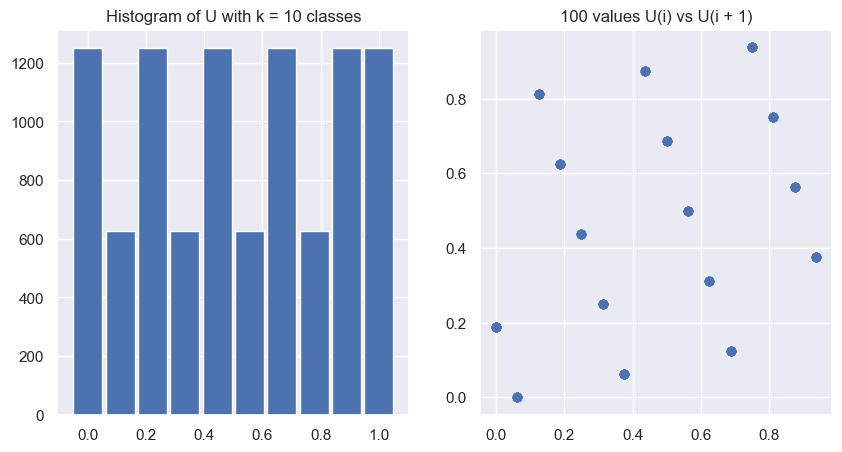

In [31]:
# Parameter values
n = 10000
x0 = 3
M = 16
a = 5
c = 1

X = LCG(a = a, c = c, M = M, x0 = x0, n = n)
U = X / M

k = 10 # Number of classes

heights = np.histogram(U, bins = k)[0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(np.linspace(0, 1, k), height = heights, width = .1, )
ax[0].set_title(f'Histogram of U with k = {k} classes')
ax[1].scatter(U[:100][1:], U[:100][:-1])
ax[1].set_title(f'100 values U(i) vs U(i + 1)')
plt.show()

We see from the plots above that the sample of 10000 pseudo random numbers on the surface does not look likely to be uniform and independently distributed. There are high and low peaks in the histogram, and the scatter plot show that there seem to be a pattern between the samples, indicating that the values are highly correlated. Statistical tests can help verify these observations.

<h3>(b) Evaluate quality of generators </h3>

In [12]:
Z, p = test_chi_square(U)
print(f'Chi-square test: test-statistic: {Z}, p-value: {p}')
Z, p = test_ks(U)
print(f'Kolmogorov-Smirnov test: test-statistic: {Z}, p-value: {p}')
Z, p = test_above_below(U)
print(f'Run test I (Above-Below): test-statistic: {Z}, p-value: {p}')
Z, p = test_up_down_knuth(U)
print(f'Run test II (Up-Down Knuth): test-statistic: {Z}, p-value: {p}')
Z, p = test_up_down_rubenstein(U)
print(f'Run test III (Up-Down Rubenstein): test-statistic: {Z}, p-value: {p}')
Z, p = test_correlation(U)
print(f'Correlation test: test-statistic: {Z}, p-value: {p}')


Chi-square test: test-statistic: 2500.0, p-value: 0.0
Kolmogorov-Smirnov test: test-statistic: 6.25756875, p-value: 0.0
Run test I (Above-Below): test-statistic: 3750, p-value: 0.6914800678415745
Run test II (Up-Down Knuth): test-statistic: 131886190.95337214, p-value: 1.0
Run test III (Up-Down Rubenstein): test-statistic: -9.875106965999812, p-value: 2.668799126482703e-23
Correlation test: test-statistic: 0.24220000125012503, p-value: 0.0


We see from these result that using Chi-square, Kolmogorov-Smirnov and run tests II and III we are able to reject the null hypothesis that the pseudo-random numbers are uniformly distributed using significance level $\alpha = 0.05$.

Using run test I we are not able to make the same conclusion since the p-value is too high.

<h3>(c) Repeat experiment with different parameter values of LCG</h3>

We have already reported bad values of $(a, c, M, x_0) = (5, 1, 16, 3)$ in the previous task. To create a LCG that work well we have experimented with different parameter values and searched the internet for inspiration. We have settled on the following values:

$M = 2^{48} $,
$a = 25214903917$,
$c = 11$,
$x_0 = 3$

We will generate a sample of 10000 pseudo-random numbers using these values and run the same tests as in the previous task

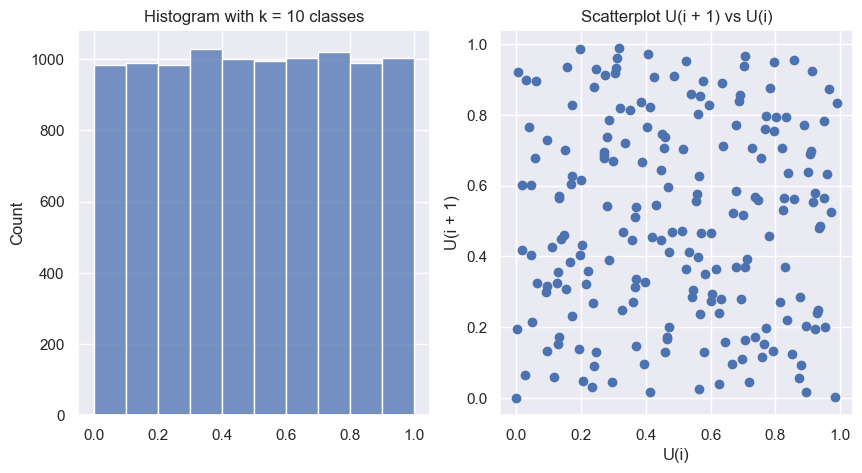

In [51]:
# a) Generate 10 000 numbers and plot them in histogram
n = 10000
k = 10
M = 2 ** 48
a = 25214903917
c = 11
x0 = 3

# Generating and plotting
nums = LCG(a, c, M, x0, n)
U = nums / M
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sbn.histplot(U, bins=k, ax=ax[0])
ax[0].set_title(f"Histogram with k = {k} classes")
ax[1].scatter(U[:200][:-1], U[:200][1:])
ax[1].set_ylabel("U(i + 1)")
ax[1].set_xlabel("U(i)")
ax[1].set_title(f"Scatterplot U(i + 1) vs U(i)")

plt.show()


In [50]:
Z, p = test_chi_square(U)
print(f'Chi-square test: test-statistic: {Z}, p-value: {p}')
Z, p = test_ks(U)
print(f'Kolmogorov-Smirnov test: test-statistic: {Z}, p-value: {p}')
Z, p = test_above_below(U)
print(f'Run test I (Above-Below): test-statistic: {Z}, p-value: {p}')
Z, p = test_up_down_knuth(U)
print(f'Run test II (Up-Down Knuth): test-statistic: {Z}, p-value: {p}')
Z, p = test_up_down_rubenstein(U)
print(f'Run test III (Up-Down Rubenstein): test-statistic: {Z}, p-value: {p}')
Z, p = test_correlation(U)
print(f'Correlation test: test-statistic: {Z}, p-value: {p}')

Chi-square test: test-statistic: 9.516, p-value: 0.9638928369705171
Kolmogorov-Smirnov test: test-statistic: 0.5817708427811435, p-value: 0.8874606871104923
Run test I (Above-Below): test-statistic: 5023, p-value: 0.49632941571012945
Run test II (Up-Down Knuth): test-statistic: 197837575.10929903, p-value: 1.0
Run test III (Up-Down Rubenstein): test-statistic: 0.6562320882129656, p-value: 0.7441625971725482
Correlation test: test-statistic: 0.25080579837339334, p-value: 1.0


For these parameters of the LCG we get from the plots that they are seemingly uniformly distributed. The vertical bars of the histogram are closely alligned but not exactly the same, indicating that there is some (pseudo) random variation in the frequency of the sample. The plot to the right show no real pattern between one sample and the next in the sequence, meaning that they are not correlated with each other. 

As for the statistical tests, none return a p-value larger than $\alpha = 0.05$, meaning that we accept the null-hypothesis of the sample coming from a uniform distribution.

<h3>(2) Apply a system RNG and perform the same tests</h3>

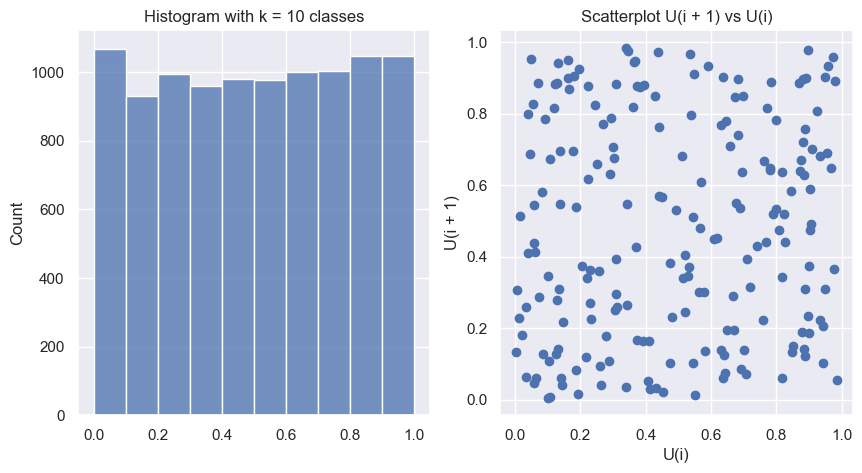

In [52]:
U = np.random.uniform(0, 1, size = 10000)

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sbn.histplot(U, bins=k, ax=ax[0])
ax[0].set_title(f"Histogram with k = {k} classes")
ax[1].scatter(U[:200][:-1], U[:200][1:])
ax[1].set_ylabel("U(i + 1)")
ax[1].set_xlabel("U(i)")
ax[1].set_title(f"Scatterplot U(i + 1) vs U(i)")

plt.show()



In [53]:
Z, p = test_chi_square(U)
print(f'Chi-square test: test-statistic: {Z}, p-value: {p}')
Z, p = test_ks(U)
print(f'Kolmogorov-Smirnov test: test-statistic: {Z}, p-value: {p}')
Z, p = test_above_below(U)
print(f'Run test I (Above-Below): test-statistic: {Z}, p-value: {p}')
Z, p = test_up_down_knuth(U)
print(f'Run test II (Up-Down Knuth): test-statistic: {Z}, p-value: {p}')
Z, p = test_up_down_rubenstein(U)
print(f'Run test III (Up-Down Rubenstein): test-statistic: {Z}, p-value: {p}')
Z, p = test_correlation(U)
print(f'Correlation test: test-statistic: {Z}, p-value: {p}')

Chi-square test: test-statistic: 20.224, p-value: 0.3812140482892272
Kolmogorov-Smirnov test: test-statistic: 1.173409121741645, p-value: 0.12734070083808358
Run test I (Above-Below): test-statistic: 4958, p-value: 0.5067025853136762
Run test II (Up-Down Knuth): test-statistic: 197728613.84687647, p-value: 1.0
Run test III (Up-Down Rubenstein): test-statistic: -1.122710319593247, p-value: 0.13078027187402996
Correlation test: test-statistic: 0.2539737534449725, p-value: 1.0


We get the same results as in the previous task. Here, however the bars of the histogram are less alligned than previously.

<h3>(3) Multiple sample test</h3>

The problem with measuring the performance of our RNG using only one sample is that it is not very fair. We may have gotten lucky with that specific starting value, and ideally our RNG should be able to perform well with any starting value. We can therefore replicate the statistical tests for multiple samples using the LCG with the same parameters except $x_0$ where we expect that the p-values are all sufficient for us to accept the null-hypothesis that the sample is uniformly distributed.

For the sake of brevity we use only the chi-square test for this purpose and the parameters of the LCG as in task (1c), varying only the starting number $x_0$.

# of p-values < 0.05 = 0 for 100 rounds


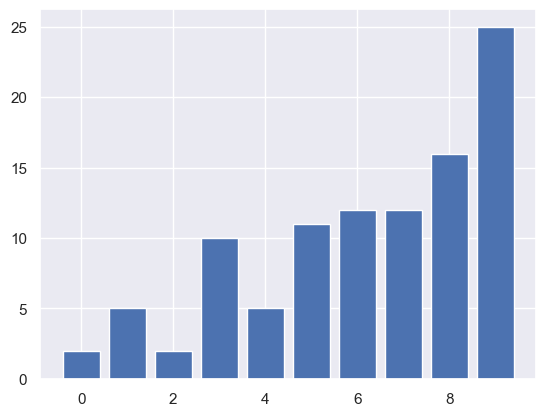

In [78]:
rounds = 100

x0s = np.random.choice(a = np.arange(0, 1000), replace = False, size=rounds)
p_vals = np.zeros(rounds)

for i, x0 in enumerate(x0s):
    X = LCG(a = a, c = c, M = M, x0 = x0)
    U = X / M
    Z, p = test_chi_square(U)
    p_vals[i] = p


n_bins = 10
hist = np.histogram(p_vals, bins = n_bins)[0]

plt.bar(x = np.arange(0, n_bins, 1), height = hist)

print(f'# of p-values < 0.05 = {(p_vals < 0.05).sum()} for {rounds} rounds')

We see from this that the number of p-values lower than an $\alpha = 0.05$ is zero, meaning that there is statistical significance to accept that the pseudo-random numbers generated using the LCG come from a uniform distribution.